# Visual Search Engines: Final Project

Using sift and the visual bag of words principle to classify pictures as one of the 10 possible animal species. The approach of this notebook is to improve the classification process.

In [1]:
import sys
sys.path.append("pySift")
from pySift import sift, matching

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

import time
from collections import Counter
import pylab as plt
from IPython import display
import pickle
from pandas.tools.plotting import scatter_matrix
import pandas as pd
import random
import itertools
from sys import getsizeof

from sklearn.neighbors import *
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.svm import *

from sklearn.gaussian_process import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import *

from sklearn.linear_model import SGDClassifier
from sklearn.cluster import *

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import *
from sklearn import preprocessing
from sklearn.metrics import *

### Constants and methods

In [168]:
class_names = ["Blue Whale", "Chiuaua", "Chimpanzee", "Fox","Gorilla", "Killer Whale", "Seal", "Tiger", "Wolf", "Zebra"]

trainimages = [line.strip().split(" ")[0] for line in open("trainset-overview.txt", "r")]
train_labels = np.array([int(line.strip().split(" ")[1]) for line in open("trainset-overview.txt", "r")])

valimages = [line.split(' ')[0] for line in open('valset-overview.txt','r')]
val_labels = np.array([int(line.rstrip().split(' ')[1]) for line in open('valset-overview.txt','r')])

testimages = [line.strip().split(' ')[0] for line in open('testset-overview-final.txt','r')]

def siftPointsPerImage(images, densepoints=True, hespoints=True, harpoints=True, sigma=1.0):
    """List of imagepaths in in, list of points per images out"""
    siftPointsPerImage = []
    for i in xrange(len(images)):
        densepoints = sift.densePoints(images[i], stride=25)
        hespoints   = sift.computeHes(images[i], sigma, magThreshold=15, hesThreshold=10, NMSneighborhood=10)
        harpoints   = sift.computeHar(images[i], sigma, magThreshold=5, NMSneighborhood=10)
        allpoints = np.concatenate((densepoints, hespoints, harpoints))
        point, siftpoints = sift.computeSIFTofPoints(images[i], allpoints, sigma, nrOrientBins=8, nrSpatBins=4, nrPixPerBin=4)
        siftPointsPerImage.append(siftpoints)
    return np.array(siftPointsPerImage)

def calculateHistograms(imagePointCollections, nr_clusters, clusters):
    '''Calculates the histogram per image by the trainingpoints of the image.'''
    n_images = len(imagePointCollections)
    histograms = np.zeros((n_images, nr_clusters))
    for i in xrange(n_images):
        siftpoints = imagePointCollections[i]
        distribution = clusters.predict(siftpoints)
        hist = np.histogram(distribution, bins=range(nr_clusters+1))
        histograms[i] = hist[0]
    return histograms

def plot_confusion_matrix(val_labels, val_predictions):
    """Plot a confusion matrix"""
    cm = confusion_matrix(val_labels, val_predictions)
    
    tick_marks = np.arange(len(class_names))
    plt.figure(figsize=(10,10))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

def splitInTwo(predictionArray):
    preds = []
    clas = []
    
    for pair in predictionArray:
        preds.append(pair[0])
        clas.append(pair[1])
    
    return preds,clas
    
def bestVotedPredictions(predictionArray):
    """Input array with predictions per classifier, count votes each prediction gets return list most voted predictions."""
    
    if len(predictionArray[0]) == 2:
        preds, clas = splitInTwo(predictionArray)
    else:
        preds = predictionArray
    
    alld = np.stack(preds, axis=0)
    newPredictions = []
    for i in alld.T:
        counts = np.bincount(i)
        max_counts = np.where(counts == counts.max())[0]
        # if multiple species share first place, 1 is randomly chosen.
        if len(max_counts) >= 2: 
            newPredictions.append(np.random.choice(max_counts, 1)[0])
        else:
            newPredictions.append(np.argmax(counts))
    return newPredictions


### Extracting features from the images

In [ ]:
trainpoints = siftPointsPerImage(trainimages)
valpoints = siftPointsPerImage(valimages)
testpoints = siftPointsPerImage(testimages)

np.save('trainingset_SiftPointsPerImage.npy',trainpoints)
np.save('validationset_SiftPointsPerImage.npy',valpoints)
np.save('testset_SiftPointsPerImage.npy',testpoints)

In [6]:
trainpoints = np.load('trainingset_SiftPointsPerImage.npy')
valpoints = np.load('validationset_SiftPointsPerImage.npy')
testpoints = np.load('testset_SiftPointsPerImage.npy')


### Optimal amount of clusters

In [7]:
k = 6000
itr = 300
org = 3
PIK = "clusters/6000/MiniBatchKMeans_K"+str(k)+"_maxiter"+str(itr)+"_original_"+str(org)+".dat"

with open(PIK, "rb") as f:
    clusters = pickle.load(f)
nr_clusters = clusters.n_clusters

In [8]:
train_feat = calculateHistograms(trainpoints, nr_clusters, clusters)
val_feat = calculateHistograms(valpoints, nr_clusters, clusters)
test_feat = calculateHistograms(testpoints, nr_clusters, clusters)
del trainpoints
del valpoints
del testpoints
del clusters

train_feat_normalized = preprocessing.normalize(train_feat, norm='l2')
val_feat_normalized = preprocessing.normalize(val_feat, norm='l2')
test_feat_normalized = preprocessing.normalize(test_feat, norm='l2')


### Using multiple classifiers

Defined several scikit-learn classifiers we wanted to use in the voting model

In [9]:
classifiers = [
    KNeighborsClassifier(n_neighbors=250, n_jobs=-1),
    SVC(C=1),
    GradientBoostingClassifier(),
    NuSVC(),
    LinearDiscriminantAnalysis(),
    SGDClassifier(n_jobs=-1),
    GaussianProcessClassifier(n_jobs=-1),
    DecisionTreeClassifier(max_depth=6),
    RandomForestClassifier(n_estimators=1000, n_jobs=-1),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    NearestCentroid()
    ]

### Voting model

Each classifier with an accuracy above the arbitrary threshold, will have a vote in the model. Per picture, the species with the most votes will win.

In [131]:
predictions = []
test_predictions = []
fscores = []
threshold = 0.4
        
for index, clf in enumerate(classifiers):
    name = clf.__class__.__name__
    
    clf.fit(train_feat_normalized, train_labels) 
    accuracy = clf.score(val_feat_normalized, val_labels)
    val_predictions = clf.predict(val_feat_normalized)
    
    if accuracy >= threshold:
        predictions.append((val_predictions, index))
        fscores.insert(index, f1_score(val_labels, val_predictions, average=None))
        print 'name:',name,'\n','accuracy:',accuracy,'\n',"="*30

val_predictions = bestVotedPredictions(predictions)
# plot_confusion_matrix(val_labels, val_predictions)
print(classification_report(val_labels, val_predictions, target_names=class_names))

accuracy = val_predictions == val_labels
print float(np.sum(accuracy))/len(accuracy)
print len(predictions)

name: KNeighborsClassifier 
accuracy: 0.355 
name: SVC 
accuracy: 0.405 
name: GradientBoostingClassifier 
accuracy: 0.395 
name: NuSVC 
accuracy: 0.445 
name: LinearDiscriminantAnalysis 
accuracy: 0.265 
name: SGDClassifier 
accuracy: 0.43 
name: GaussianProcessClassifier 
accuracy: 0.44 
name: DecisionTreeClassifier 
accuracy: 0.21 
name: RandomForestClassifier 
accuracy: 0.485 
name: MLPClassifier 
accuracy: 0.505 
name: AdaBoostClassifier 
accuracy: 0.23 
name: GaussianNB 
accuracy: 0.25 
name: NearestCentroid 
accuracy: 0.41 
Tie! randomly chosen out of shared first places
Chiuaua
Tiger
---
Chose: Tiger
---
Tie! randomly chosen out of shared first places
Gorilla
Tiger
---
Chose: Tiger
---
Tie! randomly chosen out of shared first places
Chiuaua
Wolf
---
Chose: Wolf
---
Tie! randomly chosen out of shared first places
Blue Whale
Seal
---
Chose: Seal
---
Tie! randomly chosen out of shared first places
Killer Whale
Tiger
---
Chose: Tiger
---
Tie! randomly chosen out of shared first pla


### Finding the classifiers with highest f1-score per species

In [144]:
f1_per_species = np.zeros((len(class_names),len(classifiers)))
best_classifiers = np.zeros(len(class_names))

for index_f1, clf_f1 in enumerate(fscores):
    for index_species_f1, species_f1 in enumerate(clf_f1):
        f1_per_species[index_species_f1][index_f1] = species_f1
    
for i, species in enumerate(f1_per_species):
    best_f1 = np.where(f1_per_species[i] == f1_per_species[i].max())[0]
    # if multiple species share first place, 1 is randomly chosen.
    if len(best_f1) >= 2: 
        best_classifiers[i] = np.random.choice(best_f1, 1)[0]
    else:
        best_classifiers[i] = np.argmax(f1_per_species[i])
    
print best_classifiers

[ 6.  7.  3.  6.  3.  2.  4.  7.  1.  7.]



## Choose starting point to improve
Chose to improve the voted model by adding the predictions of best classifiers per species.

In [134]:
predictions_only, cl = splitInTwo(predictions)

# No predictions as starting point
# pred_per_c = np.ones(len(predictions_only[0]))
# pred_per_c = np.negative(pred_per_c)

# Taking voted predictions as starting point
pred_per_c = np.asarray(val_predictions)


## Improve (voted) predictions
By using the predictions of the best classifier for that particular species.

In [158]:
# check results per species
for iteration in xrange(0,5):
    for i, spec in enumerate(class_names):
        # prediction belonging to the best classifier per species
        relevant_pred = predictions_only[int(best_classifiers[i])]
        # get indices of classified animals.
        for index in np.where(relevant_pred == i)[0]:
            temp = int(pred_per_c[index])

            # if image already classified
            if pred_per_c[index] != -1:
                # get corresponding classifier
                cor_clas = int(best_classifiers[temp])
                # get prediction of that classifier
                best_clas_pred = predictions[cor_clas][0][index]
                # if voted prediction is equal to prediction of 
                # the best classifier of that species
                if best_clas_pred == temp:
                    continue
                # Best classifier doesn't agree
                else:
                    if i+1 > 9:
                        pred_per_c[index] = -1
                    else:
                        pred_per_c[index] = i%len(class_names)

            # if image is not classified     
            else:
                pred_per_c[index] = i

# if all best classifiers together do not classify picture, 
# take the voted prediction.
# ONLY RELEVANT WHEN TAKING NO PREDICTIONS AS STARTING POINT
for indx, p in enumerate(pred_per_c):
    if p == -1:
        pred_per_c[indx] = val_predictions[indx]        

ac = pred_per_c == val_labels
print "="*30, '\n', "Overall accuracy:", float(np.sum(ac))/len(ac), '\n', "="*30, '\n'
print classification_report(val_labels, pred_per_c, target_names=class_names)
print confusion_matrix(val_labels, pred_per_c)

Overall accuracy: 0.535 

              precision    recall  f1-score   support

  Blue Whale       0.63      0.85      0.72        20
     Chiuaua       0.45      0.50      0.48        20
  Chimpanzee       0.56      0.50      0.53        20
         Fox       0.36      0.40      0.38        20
     Gorilla       0.43      0.30      0.35        20
Killer Whale       0.50      0.50      0.50        20
        Seal       0.47      0.35      0.40        20
       Tiger       0.76      0.80      0.78        20
        Wolf       0.35      0.35      0.35        20
       Zebra       0.76      0.80      0.78        20

 avg / total       0.53      0.54      0.53       200

[[17  0  0  0  0  1  1  0  1  0]
 [ 1 10  0  3  0  1  1  0  3  1]
 [ 1  3 10  0  3  1  0  0  1  1]
 [ 1  0  2  8  1  2  2  2  2  0]
 [ 0  3  1  4  6  1  1  0  4  0]
 [ 5  1  1  0  0 10  1  0  1  1]
 [ 2  3  3  2  0  2  7  0  0  1]
 [ 0  1  0  1  0  0  0 16  1  1]
 [ 0  1  1  4  4  0  2  1  7  0]
 [ 0  0  0  0  0  2  0  2 


### One classifier

CPU times: user 56.9 s, sys: 4.53 s, total: 1min 1s
Wall time: 33.5 s
              precision    recall  f1-score   support

  Blue Whale       0.57      0.60      0.59        20
     Chiuaua       0.48      0.50      0.49        20
  Chimpanzee       0.59      0.50      0.54        20
         Fox       0.33      0.35      0.34        20
     Gorilla       0.37      0.35      0.36        20
Killer Whale       0.44      0.40      0.42        20
        Seal       0.36      0.45      0.40        20
       Tiger       0.76      0.80      0.78        20
        Wolf       0.47      0.35      0.40        20
       Zebra       0.77      0.85      0.81        20

 avg / total       0.51      0.52      0.51       200

[[12  0  0  0  0  3  4  0  0  1]
 [ 2 10  0  2  0  0  1  0  4  1]
 [ 0  2 10  1  1  1  3  0  1  1]
 [ 0  0  1  7  5  4  2  0  1  0]
 [ 0  3  2  4  7  1  2  0  1  0]
 [ 5  1  1  0  1  8  2  1  0  1]
 [ 2  3  1  3  1  0  9  1  0  0]
 [ 0  0  0  1  1  0  0 16  1  1]
 [ 0  2  2  3  

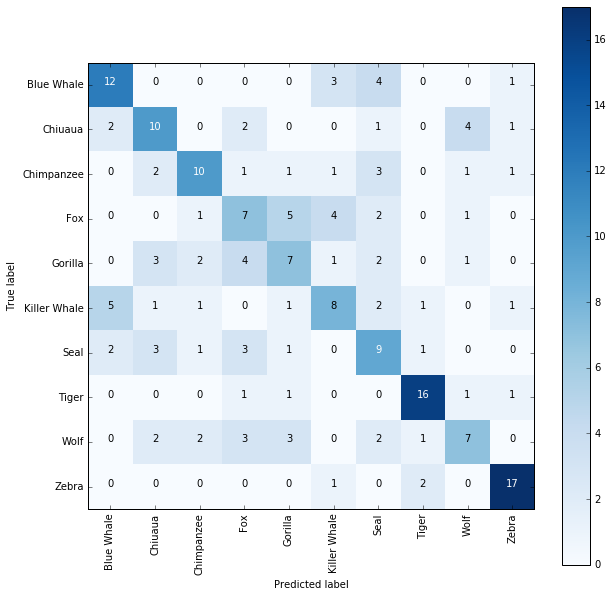

In [122]:
clf = MLPClassifier()
# clf.set_params(**SVC_params)

%time clf.fit(train_feat_normalized,train_labels)
train_predictions = clf.predict(train_feat_normalized)
train_accuracy = clf.score(train_feat_normalized, train_labels)

val_predictions = clf.predict(val_feat_normalized)
val_accuracy = clf.score(val_feat_normalized, val_labels)

print 30*'='
print(classification_report(val_labels, val_predictions, target_names=class_names))

# print val_predictions
# print val_labels
print confusion_matrix(val_labels, val_predictions)

print clf.__class__.__name__,'nr_clusters:',nr_clusters
print 'train accuracy:',train_accuracy
print 'validation accuracy:',val_accuracy

plot_confusion_matrix(val_labels, val_predictions)